In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [2]:
df = pd.read_csv("C:/Users/DELL/Desktop/沪深300.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df.head()

,Open,High,Low,Close,Volumn,Amount
Date,,,,,,
2011-03-22,3217.80,3227.80,3175.93,3222.96,572486.84,8000979.28
2011-03-23,3222.33,3267.00,3216.65,3264.93,720775.85,9854042.37
2011-03-24,3269.58,3273.37,3250.02,3251.36,613042.44,8805890.59
2011-03-25,3256.18,3304.26,3254.68,3294.48,868959.79,12202136.70
2011-03-28,3307.41,3328.07,3286.86,3290.57,976843.00,13903008.30


In [3]:
df.shape

(2431, 6)

In [177]:
# 时间点长度
time_stamp = 60

# 划分训练集与验证集
train = df[0:1944 + time_stamp]
test = df[1944 - time_stamp:]

In [178]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

In [179]:
# 训练集
x_train, y_train = [], []

for i in range(time_stamp, len(train)):
    x_train.append(train_sc[i - time_stamp:i])
    y_train.append(train_sc[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)

In [180]:
# 验证集
x_test, y_test = [], []
for i in range(time_stamp, len(test)):
    x_test.append(test_sc[i - time_stamp:i])
    y_test.append(test_sc[i, 3])

x_test, y_test = np.array(x_test), np.array(y_test)

In [181]:
print(x_train.shape)
print(x_test.shape)

(1944, 60, 6)
(487, 60, 6)


In [203]:
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
model = Sequential()
model.add(LSTM(units=15, return_sequences=True))
model.add(Dropout(0.02))
model.add(LSTM(units=15, return_sequences=False))
model.add(Dropout(0.02))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, callbacks=[early_stop])

Epoch 1/20
195/195 [==============================] - 6s 16ms/step - loss: 0.0226
Epoch 2/20
195/195 [==============================] - 3s 15ms/step - loss: 0.0015: 0s - loss
Epoch 3/20
195/195 [==============================] - 3s 15ms/step - loss: 0.0016
Epoch 4/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0012: 0s - loss: 0.001
Epoch 5/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0013
Epoch 6/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0012
Epoch 7/20
195/195 [==============================] - 3s 16ms/step - loss: 9.5732e-04
Epoch 8/20
195/195 [==============================] - 3s 16ms/step - loss: 0.0011: 0s - l
Epoch 9/20
195/195 [==============================] - 3s 16ms/step - loss: 9.1723e-04
Epoch 10/20
195/195 [==============================] - 3s 16ms/step - loss: 9.3604e-04
Epoch 11/20
195/195 [==============================] - 3s 16ms/step - loss: 8.4093e-04
Epoch 00011: early stopping


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 15)            1320      
_________________________________________________________________
dropout (Dropout)            (None, 60, 15)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 3,196
Trainable params: 3,196
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.evaluate

<bound method Model.evaluate of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000015DCDC669D0>>

In [204]:
y_pred = model.predict(x_test)
scaler.fit_transform(pd.DataFrame(test['Close'].values))
# 反归一化
y_pred_origin = scaler.inverse_transform(y_pred)
y_test_origin = scaler.inverse_transform(y_test.reshape(487,1))

mse = np.mean(np.power((y_test.reshape(487,1) - y_pred), 2))
print(mse)
print(y_pred_origin.shape)
print(y_test_origin.shape)

0.0011628933529200549
(487, 1)
(487, 1)


In [205]:
np.sqrt(np.mean(np.power((y_test_origin - y_pred_origin), 2)))

96.94557106417811

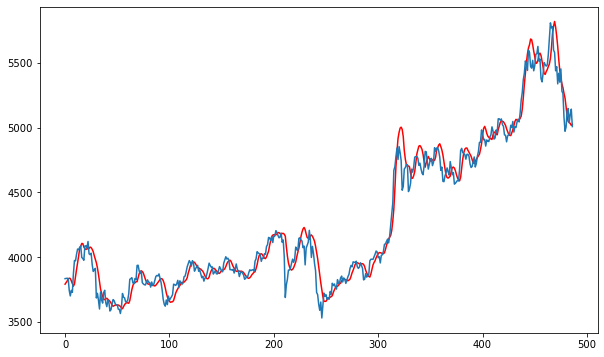

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred_origin, color='red')
plt.plot(y_test_origin)

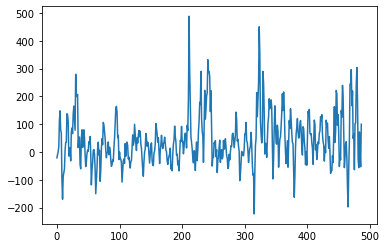

In [14]:
test_resid = y_pred_origin - y_test_origin
plt.plot(test_resid)

In [15]:
fitted_values = model.predict(x_train)
scaler.fit_transform(pd.DataFrame(test['Close'].values))
# 反归一化
fitted_origin = scaler.inverse_transform(fitted_values)
y_train_origin = scaler.inverse_transform(y_train.reshape(1944,1))

mse = np.mean(np.power((y_train.reshape(1944,1) - fitted_values), 2))
print(mse)

0.0005909928623287263


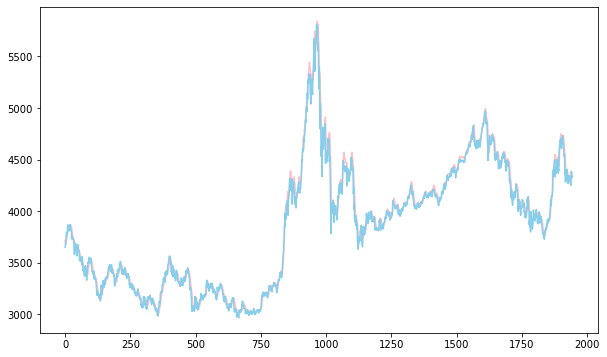

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(fitted_origin, color="pink")
plt.plot(y_train_origin, color="skyblue")

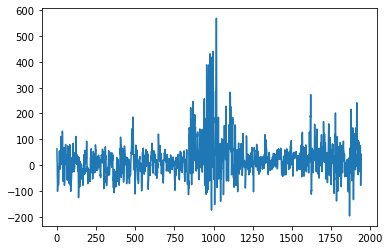

In [17]:
train_resid = fitted_origin - y_train_origin
plt.plot(train_resid)

In [18]:
resid = np.vstack((train_resid,test_resid))

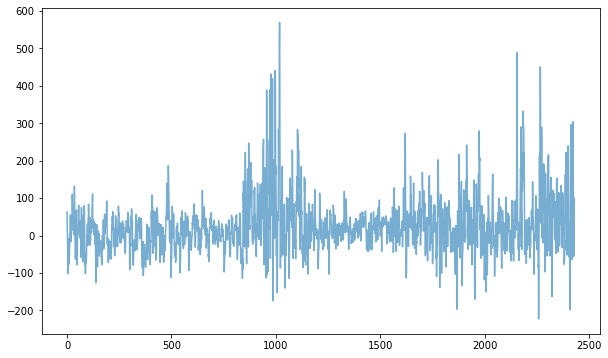

In [164]:
plt.figure(figsize=(10, 6))
plt.plot(resid, alpha=0.6)

In [20]:
from datetime import datetime
import statsmodels.api as sm     #acf,pacf图
from statsmodels.tsa.stattools import adfuller  #adf检验
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

In [21]:
ts = pd.DataFrame(resid)

In [22]:
ts.index = df.index
ts.columns = ["Close"]

In [23]:
ts = ts["Close"]

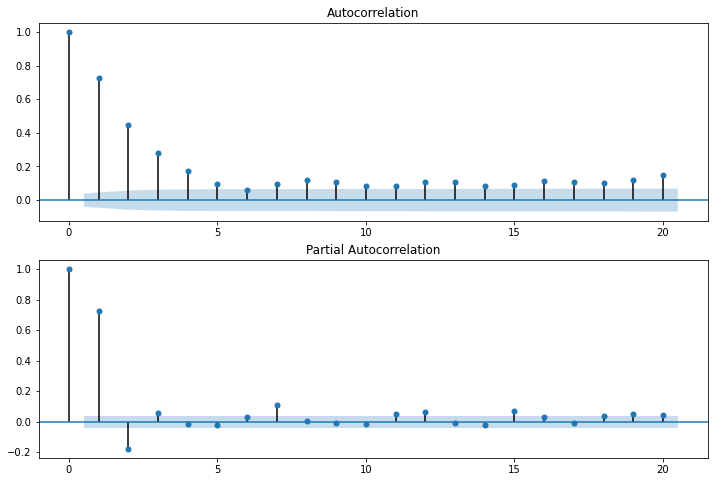

In [24]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts,lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts,lags=20,ax=ax2)
plt.show()

In [25]:
temp = np.array(ts)
t = adfuller(temp, regression='ct', autolag='BIC')  # ADF检验
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
output

,value
Test Statistic Value,-22.356
p-value,0
Lags Used,1
Number of Observations Used,2429
Critical Value(1%),-3.9625
Critical Value(5%),-3.4123
Critical Value(10%),-3.12812


In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
#对模型进行定阶
pmax = 10 #int(len(df) / 10)    #一般阶数不超过 length /10
qmax = 10 #int(len(df) / 10)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(ts, (p, 0, q)).fit().bic)
        except:
            temp.append(None)
    bic_matrix.append(temp)

bic_matrix = pd.DataFrame(bic_matrix)   #将其转换成Dataframe 数据结构
p,q = bic_matrix.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC最小的p值和q值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,1
#所以可以建立ARIMA 模型，ARIMA(0,1,1)

BIC最小的p值和q值：5,3


In [28]:
bic_matrix

,0,1,2,3,4,5,6,7,8,9,10
0,27691.655063,26279.901891,25931.894120,25858.812113,25838.372198,25799.893559,25807.042456,25813.504418,25820.957245,25821.584821,25822.619857
1,25875.310362,25795.270462,25802.930034,25810.268642,25817.237467,25807.228854,25787.812167,25791.771033,25794.021726,25801.431819,NaN
2,25803.681757,25802.951194,25784.557176,25791.815995,25823.283615,25809.894304,25793.627870,25796.255947,25801.674608,25809.304851,NaN
3,25802.840638,25810.314875,25791.774110,25812.227907,25774.028914,25800.362436,NaN,25770.060178,NaN,NaN,NaN
4,25810.003268,25817.566361,25766.775982,25774.253859,25781.677590,25762.008681,25766.650710,25774.362202,NaN,NaN,NaN
5,25816.129338,25823.664040,25774.184877,25751.479207,25758.767692,25766.500341,NaN,NaN,NaN,NaN,NaN
6,25821.530827,25797.676660,25781.100370,25758.799781,25765.997178,25773.140703,NaN,NaN,NaN,NaN,NaN
7,25799.039627,25806.789872,25786.911382,25766.496665,25773.353779,25777.396101,25783.448814,NaN,NaN,NaN,NaN
8,25806.781534,25814.555483,25822.189316,25800.067992,NaN,25784.891262,25789.801734,25797.049314,NaN,NaN,NaN
9,25814.351629,25822.110183,25809.414351,25797.560173,25785.561702,25792.683166,25800.459469,25802.595831,NaN,NaN,NaN


In [230]:
#具体模型信息
model = ARIMA(ts, (p,0,q)).fit()
model.summary2()  

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 25751.4792
Dependent Variable: Close            Log-Likelihood:      -12837.   
Date:               2021-04-15 00:09 Scale:               1.0000    
No. Observations:   2431             Method:              css-mle   
Df Model:           9                Sample:              0         
Df Residuals:       2422                                  1         
Converged:          1.0000           S.D. of innovations: 47.521    
No. Iterations:     96.0000          HQIC:                25714.591 
AIC:                25693.5186                                      
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           26.1511    9.1989    2.8429  0.0045   8.1217  44.1806
ar.L1.Close      2.0446    0.0242   84.4656  0.0000   1.9972   2.0920
ar.L2.Close     -2.3810    0.0499  -47.7140  0.0000  -2.4788  -2.2832
ar.L3.Close      2.2213    0.0506   43.9121  0.0000   2.1221   2.3204
ar.L4.Close     -1.1151    0.0409  -27.2344  0.0000  -1.1953  -1.0348
ar.L5.Close      0.2270    0.0203   11.1657  0.0000   0.1872   0.2669
ma.L1.Close     -1.1879    0.0157  -75.7011  0.0000  -1.2186  -1.1571
ma.L2.Close      1.1459    0.0289   39.7046  0.0000   1.0894   1.2025
ma.L3.Close     -0.9260    0.0203  -45.5113  0.0000  -0.9659  -0.8861
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.0825            -1.0186           1.0220            -0.2371
AR.2            0.0825             1.0186           1.0220             0.2371
AR.3            1.0051            -0.0000           1.0051            -0.0000
AR.4            1.8710            -0.8340           2.0485            -0.0667
AR.5            1.8710             0.8340           2.0485             0.0667
MA.1            1.0188            -0.0000           1.0188            -0.0000
MA.2            0.1094            -1.0237           1.0296            -0.2331
MA.3            0.1094             1.0237           1.0296             0.2331
====================================================================

"""

In [256]:
fitted = model.predict()
# model.fittedvalues

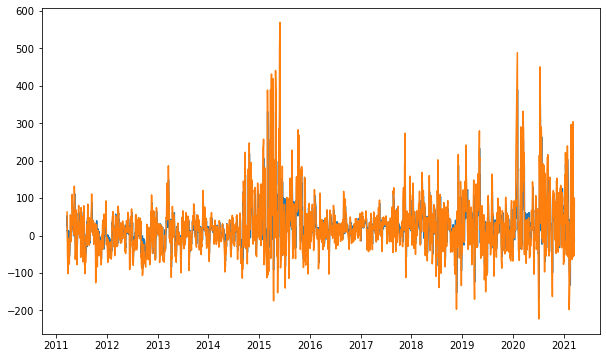

In [265]:
plt.figure(figsize=(10,6))
plt.plot(fitted)
plt.plot(ts)

In [264]:
res = model.fittedvalues - ts  #model.resid
from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(res, lags=[6,12])) 

(array([ 4.34830958, 11.58680754]), array([0.62965181, 0.47940749]))


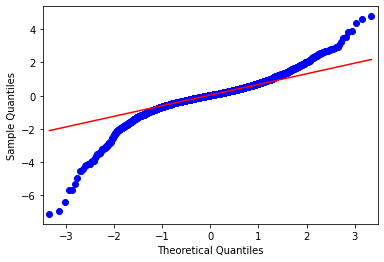

In [263]:
from statsmodels.graphics.api import qqplot
fig = plt.figure()
ax = fig.add_subplot(111)
fig = qqplot(res, line='q', ax=ax, fit=True)

In [32]:
from sklearn.metrics import mean_squared_error
train, test = ts[0:1944], ts[1944:len(ts)]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model_fit = ARIMA(history, order=(p,0,q)).fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=55.148172, expected=-21.149035
predicted=-17.393203, expected=-8.762754
predicted=-5.929079, expected=0.233268
predicted=6.916729, expected=19.843775
predicted=37.994174, expected=112.932568
predicted=109.212133, expected=148.048793
predicted=101.154095, expected=78.962342
predicted=41.029435, expected=67.340107
predicted=65.952355, expected=-97.764096
predicted=-82.849811, expected=-169.974143
predicted=-121.162359, expected=-88.944180
predicted=-39.639537, expected=-75.751727
predicted=-39.502568, expected=-61.162152
predicted=-16.528068, expected=3.900150
predicted=28.895681, expected=33.805840
predicted=24.204502, expected=34.913254
predicted=25.806095, expected=137.610965
predicted=130.157394, expected=132.981145
predicted=95.272567, expected=110.055102
predicted=69.498607, expected=-14.817564
predicted=-30.683097, expected=-12.690684
predicted=9.388095, expected=15.066357
predicted=23.352498, expected=-32.003752
predicted=-30.541690, expected=71.065758
predicted=79.6535

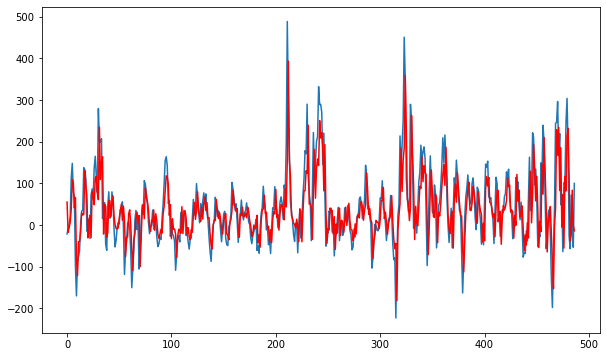

In [239]:
test = np.array(test).reshape(487,1)
predictions = np.array(predictions)
# plot
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(predictions, color='red')

In [34]:
justified = y_pred_origin - predictions

In [35]:
np.mean(np.power((y_test_origin - justified), 2))

3805.645326860968

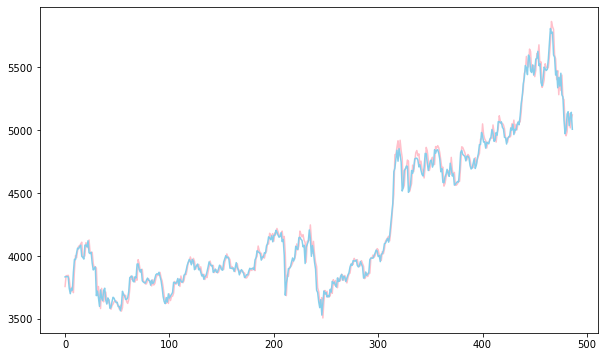

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(justified, color='pink')
plt.plot(y_test_origin,color='skyblue')

In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance

In [38]:
df = pd.read_csv("C:/Users/DELL/Desktop/沪深300.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)
df = pd.DataFrame(df["Close"])

In [39]:
# 时间点长度
time_stamp = 60

# 划分训练集与验证集
train = df[0:1944 + time_stamp]
test = df[1944 - time_stamp:]

In [40]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

In [41]:
# 训练集
x_train, y_train = [], []

for i in range(time_stamp, len(train)):
    x_train.append(train_sc[i - time_stamp:i])
    y_train.append(train_sc[i])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(1944,60)

In [42]:
# 验证集
x_test, y_test = [], []
for i in range(time_stamp, len(test)):
    x_test.append(test_sc[i - time_stamp:i])
    y_test.append(test_sc[i])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = x_test.reshape(487,60)

In [43]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
xgb_pred = model.predict(x_test)
xgb_pred = xgb_pred.reshape(487,1)

In [45]:
xgb_pred_origin = scaler.inverse_transform(xgb_pred)
y_test_origin = scaler.inverse_transform(y_test)

In [122]:
#np.sqrt(np.mean(np.power((y_test_origin - xgb_pred_origin), 2)))
#np.mean(abs(y_test_origin - xgb_pred_origin))
np.mean(abs((y_test_origin - xgb_pred_origin)/y_test_origin))

0.012457346425624386

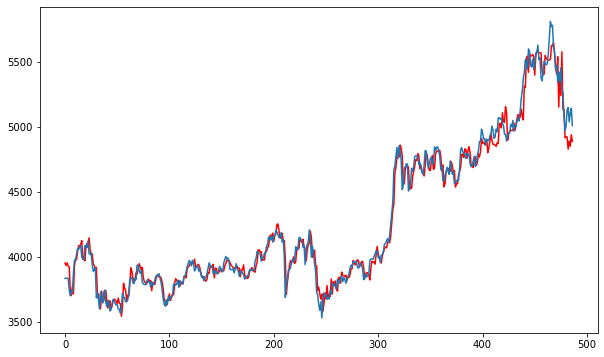

In [172]:
plt.figure(figsize=(10, 6))
plt.plot(xgb_pred_origin, color='red')
plt.plot(y_test_origin)

In [47]:
np.mean(np.power((y_test_origin - xgb_pred_origin), 2))

5928.610916354651

In [68]:
# justified
# xgb_pred_origin
# y_test_origin

In [48]:
a = (justified * y_test_origin).sum() - (xgb_pred_origin * y_test_origin).sum() - (justified * xgb_pred_origin).sum() + (xgb_pred_origin * xgb_pred_origin).sum()

In [49]:
b = ((justified - xgb_pred_origin) ** 2).sum()

In [50]:
lam = a/b

In [210]:
lam

0.8250110321776464

In [51]:
final = lam * justified + (1-lam) * xgb_pred_origin

In [52]:
np.mean(np.power((y_test_origin - final), 2))

3705.528708436705

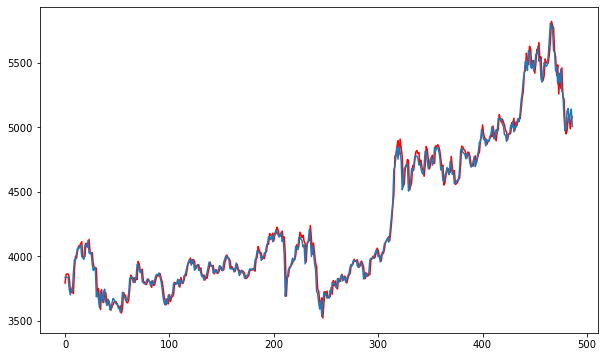

In [212]:
plt.figure(figsize=(10, 6))
plt.plot(final, color='red')
plt.plot(y_test_origin)

In [207]:
#RMSE
a = np.sqrt(np.mean(np.power((y_test_origin - y_pred_origin), 2)))
b = np.sqrt(np.mean(np.power((y_test_origin - justified), 2)))
c = np.sqrt(np.mean(np.power((y_test_origin - final), 2)))
print("LSTM:",a)
print("LSTM-ARIMA:",b)
print("LSTM-ARIMA-XGBoost:",c)

LSTM: 96.94557106417811
LSTM-ARIMA: 61.68991268320104
LSTM-ARIMA-XGBoost: 60.873054042299415


In [208]:
#MAE
d = np.mean(abs(y_test_origin - y_pred_origin))
e = np.mean(abs(y_test_origin - justified))
f = np.mean(abs(y_test_origin - final))
print("LSTM:",d)
print("LSTM-ARIMA:",e)
print("LSTM-ARIMA-XGBoost:",f)

LSTM: 68.72612351209574
LSTM-ARIMA: 44.458749240262065
LSTM-ARIMA-XGBoost: 43.659628742853215


In [209]:
#MAPE
g = np.mean(abs((y_test_origin - y_pred_origin)/y_test_origin))
h = np.mean(abs((y_test_origin - justified)/y_test_origin))
i = np.mean(abs((y_test_origin - final)/y_test_origin))
print("LSTM:",g)
print("LSTM-ARIMA:",h)
print("LSTM-ARIMA-XGBoost:",i)

LSTM: 0.015973948824148914
LSTM-ARIMA: 0.010291341356280046
LSTM-ARIMA-XGBoost: 0.010117690651390582


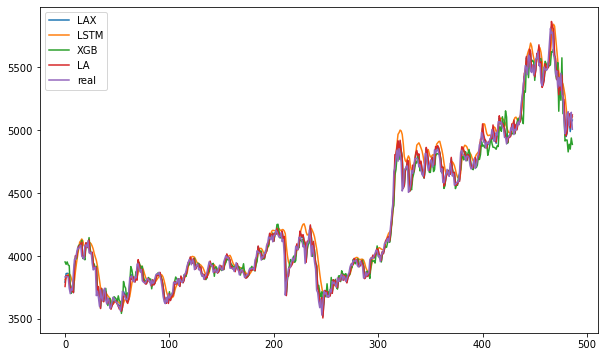

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(final, label='LAX')
plt.plot(y_pred_origin, label='LSTM')
plt.plot(xgb_pred_origin, label='XGB')
plt.plot(justified, label='LA')
plt.plot(y_test_origin, label='real')
plt.legend()

In [65]:
df = pd.read_csv("C:/Users/DELL/Desktop/沪深300.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(['Date'], drop=True)

In [66]:
# 时间点长度
time_stamp = 1

# 划分训练集与验证集
train = df[0:1944 + time_stamp]
test = df[1944 - time_stamp:]

In [67]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

In [72]:
# 训练集
x_train, y_train = [], []

for i in range(time_stamp, len(train)):
    x_train.append(train_sc[i - time_stamp:i])
    y_train.append(train_sc[i, 3])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(1944,6)

In [89]:
# 验证集
x_test, y_test = [], []
for i in range(time_stamp, len(test)):
    x_test.append(test_sc[i - time_stamp:i])
    y_test.append(test_sc[i, 3])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = x_test.reshape(487,6)

In [109]:
#用于时间序列预测的简单人工神经网络ANN
ann = Sequential()
ann.add(Dense(200, input_dim=6, activation='relu'))
ann.add(Dense(200, activation='relu'))
ann.add(Dense(1))
ann.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
ann.fit(x_train, y_train, epochs=100, batch_size=10, verbose=1, shuffle=False)

Epoch 1/100
195/195 [==============================] - 0s 492us/step - loss: 0.0089
Epoch 2/100
195/195 [==============================] - 0s 514us/step - loss: 3.4267e-04
Epoch 3/100
195/195 [==============================] - 0s 483us/step - loss: 3.5944e-04
Epoch 4/100
195/195 [==============================] - 0s 492us/step - loss: 3.8179e-04
Epoch 5/100
195/195 [==============================] - 0s 488us/step - loss: 4.8799e-04
Epoch 6/100
195/195 [==============================] - 0s 483us/step - loss: 7.7163e-04
Epoch 7/100
195/195 [==============================] - 0s 494us/step - loss: 7.9873e-04
Epoch 8/100
195/195 [==============================] - 0s 529us/step - loss: 6.3594e-04
Epoch 9/100
195/195 [==============================] - 0s 530us/step - loss: 6.1557e-04
Epoch 10/100
195/195 [==============================] - 0s 535us/step - loss: 6.8525e-04
Epoch 11/100
195/195 [==============================] - 0s 514us/step - loss: 7.3406e-04
Epoch 12/100
195/195 [============

In [113]:
ann_pred = ann.predict(x_test)
scaler.fit_transform(pd.DataFrame(test['Close'].values))
# 反归一化
ann_pred_origin = scaler.inverse_transform(ann_pred)
y_test_origin = scaler.inverse_transform(y_test.reshape(487,1))

print(ann_pred_origin.shape)
print(y_test_origin.shape)

(487, 1)
(487, 1)


In [119]:
np.sqrt(np.mean(np.power((y_test_origin - ann_pred_origin), 2)))
np.mean(abs(y_test_origin - ann_pred_origin))
np.mean(abs((y_test_origin - ann_pred_origin)/y_test_origin))

0.014708177567214736

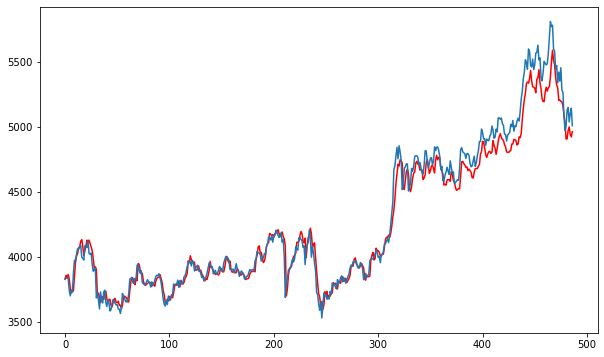

In [173]:
plt.figure(figsize=(10, 6))
plt.plot(ann_pred_origin, color='red')
plt.plot(y_test_origin)

In [277]:
final1 = pd.DataFrame(final)
real = pd.DataFrame(y_test_origin)

In [278]:
log_est = np.log(final1/final1.shift(1))
log_real = np.log(real/real.shift(1))

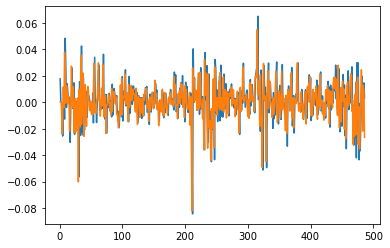

In [280]:
plt.plot(log_est)
plt.plot(log_real)

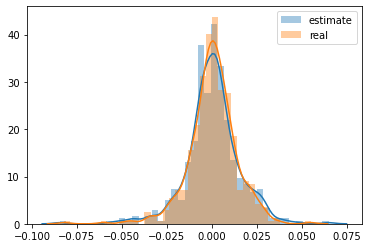

In [319]:
import seaborn as sns
import math
fig = sns.distplot(log_est.dropna())
fig = sns.distplot(log_real.dropna())
fig.legend(["estimate","real"])

In [329]:
pred = pd.DataFrame(y_pred_origin)
real = pd.DataFrame(y_test_origin)

In [330]:
log_est = np.log(pred/pred.shift(1))
log_real = np.log(real/real.shift(1))

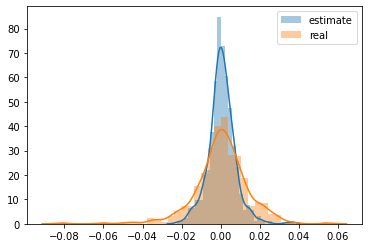

In [331]:
fig = sns.distplot(log_est.dropna())
fig = sns.distplot(log_real.dropna())
fig.legend(["estimate","real"])

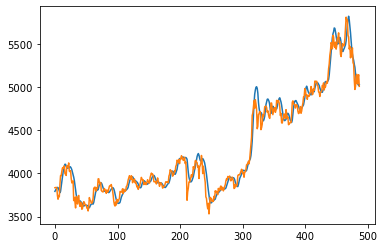

In [325]:
plt.plot(pred)
plt.plot(real)

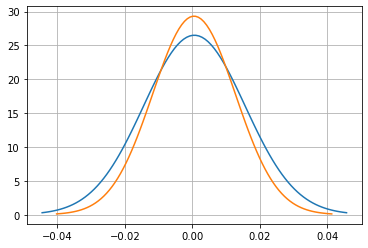

In [317]:
mu = np.array(log_est.mean())
sig = np.array(log_est.std())

x = np.linspace(mu - 3*sig, mu + 3*sig, 100)
y = np.exp(-(x - mu) ** 2 / (2 * sig ** 2)) / (math.sqrt(2*math.pi) * sig)
plt.plot(x, y)
plt.grid()

mu1 = np.array(log_real.mean())
sig1 = np.array(log_real.std())

a = np.linspace(mu1 - 3*sig1, mu1 + 3*sig1, 100)
b = np.exp(-(x - mu1) ** 2 / (2 * sig1 ** 2)) / (math.sqrt(2*math.pi) * sig1)
plt.plot(a, b)